In [1]:
# import modules
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

In [2]:
# load data
df = pickle.load(open('data/abc_regression_modeling.p', 'rb')) # rb is reading
df.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [3]:
# shuffle data
df = shuffle(df)

In [4]:
# drop unecessary columns
df.drop('customer_id', axis = 1, inplace = True)

In [5]:
# deal with missing value
print(df.isna().sum())
df.dropna(how = 'any', inplace = True) # we don't need to use imputer in this case since we have a very small amount of na records

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
avg_basket_value          0
dtype: int64


In [6]:
# identify outliers (exploration)
df_description = df.describe()
df_description # distance_from_store, total_sales, and total_items seem to have outliers


,distance_from_store,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,2.021041,0.596117,0.509589,1846.502538,278.304569,44.926396,4.312183,36.781487
std,2.566045,0.101352,0.294504,1767.829482,214.236424,21.248012,0.725054,19.337336
min,0.000000,0.260000,0.002000,45.950000,10.000000,4.000000,2.000000,9.342000
25%,0.710000,0.530000,0.263000,942.067500,201.000000,41.000000,4.000000,22.406953
50%,1.645000,0.590000,0.510500,1471.490000,258.500000,50.000000,4.000000,30.365417
75%,2.910000,0.660000,0.771500,2104.727500,318.500000,53.000000,5.000000,47.208474
max,44.370000,0.880000,1.000000,9878.760000,1187.000000,109.000000,5.000000,102.335417


In [7]:
# deal with outliers using the boxplot approach
outlier_columns = [
    'distance_from_store', 
    'total_sales', 
    'total_items'
]

for col in outlier_columns:
    # calculate lower and upper quartiles
    lower_quartile = df[col].quantile(0.25)
    upper_quartile = df[col].quantile(0.75)

    # caluclate interquartile range
    iqr = upper_quartile - lower_quartile

    # calucalte extended interquartile range using a factor of 2
    iqr_extended = iqr * 2

    # calcualte max and min borders using extended iqr (these are the vertical ticks outside the boxplot)
    max_border = upper_quartile + iqr_extended
    min_border = lower_quartile - iqr_extended

    # return index value for outliers
    outliers = df[(df[col] < min_border) | (df[col] > max_border)].index 

    # print results
    print(f'Column [{col}]: Removed {len(outliers)} Outliers. \n \t Index: {outliers}')

    # remove outliers
    df.drop(outliers, inplace = True)

Column [distance_from_store]: Removed 2 Outliers. 
 	 Index: Int64Index([733, 35], dtype='int64')
Column [total_sales]: Removed 23 Outliers. 
 	 Index: Int64Index([804, 819, 852, 782, 798, 793, 791, 797, 786, 794, 809, 811, 816,
            842, 790, 780, 850, 800, 789, 788, 808, 806, 784],
           dtype='int64')
Column [total_items]: Removed 0 Outliers. 
 	 Index: Int64Index([], dtype='int64')


In [8]:
# split input and output variables
X = df.drop(['customer_loyalty_score'], axis = 1) # input vairables
y = df['customer_loyalty_score'] # output variable

In [9]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [10]:
# deal with categorical variables
categorical_vars = ['gender']

# enstantiate one hot encoder object and apply to training and test data
one_hot_encoder = OneHotEncoder(sparse = False, drop = 'first') # returns array, drops one of the binary categorical columns to reduce multicollinearity

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# create object to get feature names
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# create data frame with encoder variables and feature names, and concat to original data frame and reset index
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index (drop = True), X_train_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_train.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index (drop = True), X_test_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_test.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

Optimal Number of Features: 8 



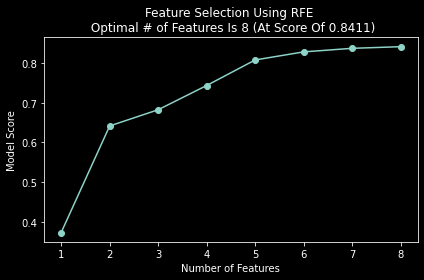

In [11]:
# feature selection

# instantiate regression and feature selecter object
regressor = LinearRegression()
feature_selector = RFECV(regressor)

# learn relationships
fit = feature_selector.fit(X_train, y_train)

# determine optimal number of features based on cross validation
optimal_feature_count = feature_selector.n_features_
print(f'Optimal Number of Features: {optimal_feature_count} \n')

# create new dataframe with selected features
X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

# plot results to visually determine best number of features
plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), fit.cv_results_['mean_test_score'], marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection Using RFE \n Optimal # of Features Is {optimal_feature_count} (At Score Of {round(max(fit.cv_results_['mean_test_score']),4)})")
plt.tight_layout()
plt.show()

In [12]:
# train model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [13]:
# predict on the test set
y_pred = regressor.predict(X_test)
y_pred

array([ 0.34879724,  0.76056613,  0.55804958,  0.36011801,  0.79446469,
        0.47603014,  0.75235976,  0.6300175 ,  0.69031925,  0.22637129,
        1.00761474,  0.83191862,  0.20522525,  0.72557312,  0.44098365,
        0.5640242 ,  0.58582914,  0.21358413,  0.5980985 ,  0.06702583,
        0.72506836,  0.10315341,  0.96017106,  0.35029911,  0.53563444,
        0.27914848,  0.59666589,  0.68231781,  0.69263445,  0.70602287,
        0.69495223,  0.81231828,  0.17952814,  0.64392751,  0.82622978,
        0.45346575,  0.4638082 ,  0.84903964,  0.51547651,  0.16388248,
        0.0047303 ,  0.92111903,  0.59337099,  0.18549731,  0.66746172,
        0.72921309,  0.72385317,  0.79016661, -0.01041561,  0.63441919,
        0.77837202,  0.7274696 ,  0.64937669,  0.99607169,  0.5412394 ,
        0.3980216 ,  0.4107998 ,  0.73336483,  0.6475787 ,  0.36715261,
        0.30437377,  0.64221301,  0.25371974, -0.07909544,  0.7263272 ,
        0.53200962,  0.70057381,  0.94684443,  0.49457602,  0.49

In [14]:
# calculate R-Squared
r_squared = r2_score(y_test, y_pred)
print(f'R-Squared = {r_squared}')

R-Squared = 0.8479915305349701


In [15]:
# cross validation
cv = KFold(n_splits = 4, shuffle = True)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = 'r2')
print(f'Cross Validation Score: {cv_scores.mean()}')

Cross Validation Score: 0.8464841185082496


In [16]:
# calculate adjusted r-squared
num_data_points, num_input_vars = X_test.shape # output of .shape is the number of rows and columns
adjusted_r_squared = 1 - (1 - r_squared) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(f'Adjusted R-Squared = {adjusted_r_squared}')

Adjusted R-Squared = 0.8292827958315818


In [17]:
# extract model coefficients
coefficients = pd.DataFrame(regressor.coef_)
input_var_names = pd.DataFrame(X_train.columns)
summary_coef = pd.concat([input_var_names, coefficients], axis = 1)
summary_coef.columns = ['input_variable', 'coefficient']

summary_coef

,input_variable,coefficient
0,distance_from_store,-0.186273
1,credit_score,0.021037
2,total_sales,0.000126
3,total_items,0.000970
4,transaction_count,-0.004564
5,product_area_count,0.059015
6,avg_basket_value,-0.003003
7,gender_M,0.016302


In [18]:
# extract model intercept
intercept = regressor.intercept_
print(f'Intercept: {intercept}')

Intercept: 0.44431340247788736


In [19]:
# multiple regression formula

# replace with desired input values (consider scaling)
input_values = {
    'distance_from_store':  0,
    'credit_score':         0,
    'total_sales':          0,
    'total_items':          0,
    'transaction_count':    0,
    'product_area_count':   0,
    'avg_basket_value':     0,
    'gender_M':             0
}  

# calculate multiple regression prediction
predicted_output = (
    (coefficients[0][0] * input_values['distance_from_store']) +
    (coefficients[0][1] * input_values['credit_score']) +
    (coefficients[0][2] * input_values['total_sales']) +
    (coefficients[0][3] * input_values['total_items']) +
    (coefficients[0][4] * input_values['transaction_count']) +
    (coefficients[0][5] * input_values['product_area_count']) +
    (coefficients[0][6] * input_values['avg_basket_value']) +
    (coefficients[0][7] * input_values['gender_M']) +
    intercept
)

# print output
print(f"""
With the following input values;
distance_from_store = {input_values['distance_from_store']}
credit_score = {input_values['credit_score']}
total_sales = {input_values['total_sales']}
total_items = {input_values['total_items']}
transaction_count = {input_values['transaction_count']}
product_area_count = {input_values['product_area_count']}
avg_basket_value = {input_values['avg_basket_value']}
gender_M = {input_values['gender_M']}

The predicted output is: {predicted_output}
""")


With the following input values;
distance_from_store = 0
credit_score = 0
total_sales = 0
total_items = 0
transaction_count = 0
product_area_count = 0
avg_basket_value = 0
gender_M = 0

The predicted output is: 0.44431340247788736

